### PulsarClassifier.ipynb

 Copyright (C) ‹ 2019 › ‹ Anna Scaife - anna.scaife@manchester.ac.uk › 

This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this program. If not, see http://www.gnu.org/licenses/.

---

**[AMS - 190215]**  Notebook created for **Chris Engelbrecht Summer School, Sani Pass, Jan 2019**<br> 
**[AMS - 190910]**  Notebook updated for **CERN School of Computing, Cluj-Napoca, Sept 2019**<br> 
**[AMS - 191015]**  Notebook updated for **DARA Big Data Hackathon, Windhoek, Oct 2019**<br> 
**[AMS - 191023]**  Notebook updated for **VizAfrica Tutorial, Gaborone, Nov 2019**<br> 


This notebook was created for the CHPC/NITheP [2019 Chris Engelbrecht Summer School](https://quantum.ukzn.ac.za/2019-chris-engelbrecht-summer-school/) on the Foundations of Theoretical and Computational Science. It was inspired by [Rob Lyon](http://www.scienceguyrob.com)'s pulsar classification tutorials in the [IAU OAD Data Science Toolkit](https://github.com/astro4dev/OAD-Data-Science-Toolkit/tree/master/Teaching%20Materials/Machine%20Learning/Supervised%20Learning/Examples/PPC).

---

The __learning objectives__ of this tutorial are:

 - visualise feature data in python (matplotlib/seaborn/datashader/holoview)
 - understand train/test splits
 - build a simple random forest classifier
 - understand k-fold validation
 - understand hyper-parameter tuning
 - visualise machine learning evaluation metrics (scikit-plot)
 - visualise feature importances (matplotlib)

---

Keep track of your progress:

- [ ] Exercise 1 (basic)
- [ ] Exercise 2 (basic)
- [ ] Exercise 3 (basic)
- [ ] Exercise 4 (basic)
- [ ] Exercise 5 (basic)
- [ ] Exercise 6 (intermediate)

---

First we import some libraries:

In [1]:
import pandas as pd   # for data handling
import numpy as np    # for array stuff
import pylab as pl    # for plotting stuff
import seaborn as sns # for pretty plotting stuff

We'll use the datashader visualisation library for plots with thousands of data points:

In [30]:
import datashader as ds
import datashader.utils as utils
import datashader.transfer_functions as tf

We'll use the holoview visualisation library for interactive plots:

In [ ]:
import holoviews as hv
from holoviews import opts
from holoviews.operation.datashader import datashade, shade, dynspread, rasterize
from holoviews.operation import decimate

We'll use the scikit-learn library for the machine learning tasks, so let's import a whole bunch of stuff from there:

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

The scikit-plot library can be used to visualise machine learning performance metrics:

In [3]:
import scikitplot as skplt

---

We're going to import the [HTRU2 dataset](https://archive.ics.uci.edu/ml/datasets/HTRU2):

In [7]:
df = pd.read_csv('./pulsar.csv')

The first row of the CSV file tells us what the features are:

In [8]:
feature_names = df.columns.values[0:-1]
print(feature_names)

['mean_int_pf' 'std_pf' 'ex_kurt_pf' 'skew_pf' 'mean_dm' 'std_dm'
 'kurt_dm' 'skew_dm']


and we can check just how much data we're dealing with:

In [9]:
# Show some information
print ('Dataset has %d rows and %d columns including features and labels'%(df.shape[0],df.shape[1]))

Dataset has 17898 rows and 9 columns including features and labels


We're going to start by separating the numerical feature data from class labels for all the candidates. To get the feature data on its own we can just strip off the column containing the class labels:

In [10]:
features = df.drop('class', axis=1)

The labels for each object tell us abut the target class and we can create an array of those data by extracting the column from the original dataset:

In [11]:
targets = df['class']

Let's take a look at how the two classes are distributed in parameter space. We'll plot the value of one feature against another and colour code the data samples according to their class. Let's start with a pretty basic plot using the matplotlib library:

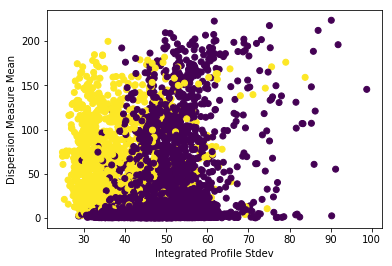

In [13]:
pl.subplot(111)
pl.scatter(df['std_pf'], df['mean_dm'],c=df['class'])
pl.xlabel('Integrated Profile Stdev')
pl.ylabel('Dispersion Measure Mean')
pl.show()

---

**Exercise 1:** try plotting different combinations of features and see if there are any clear divisions.

---

To create something a bit more fancy we can use the [seaborn library](https://seaborn.pydata.org):

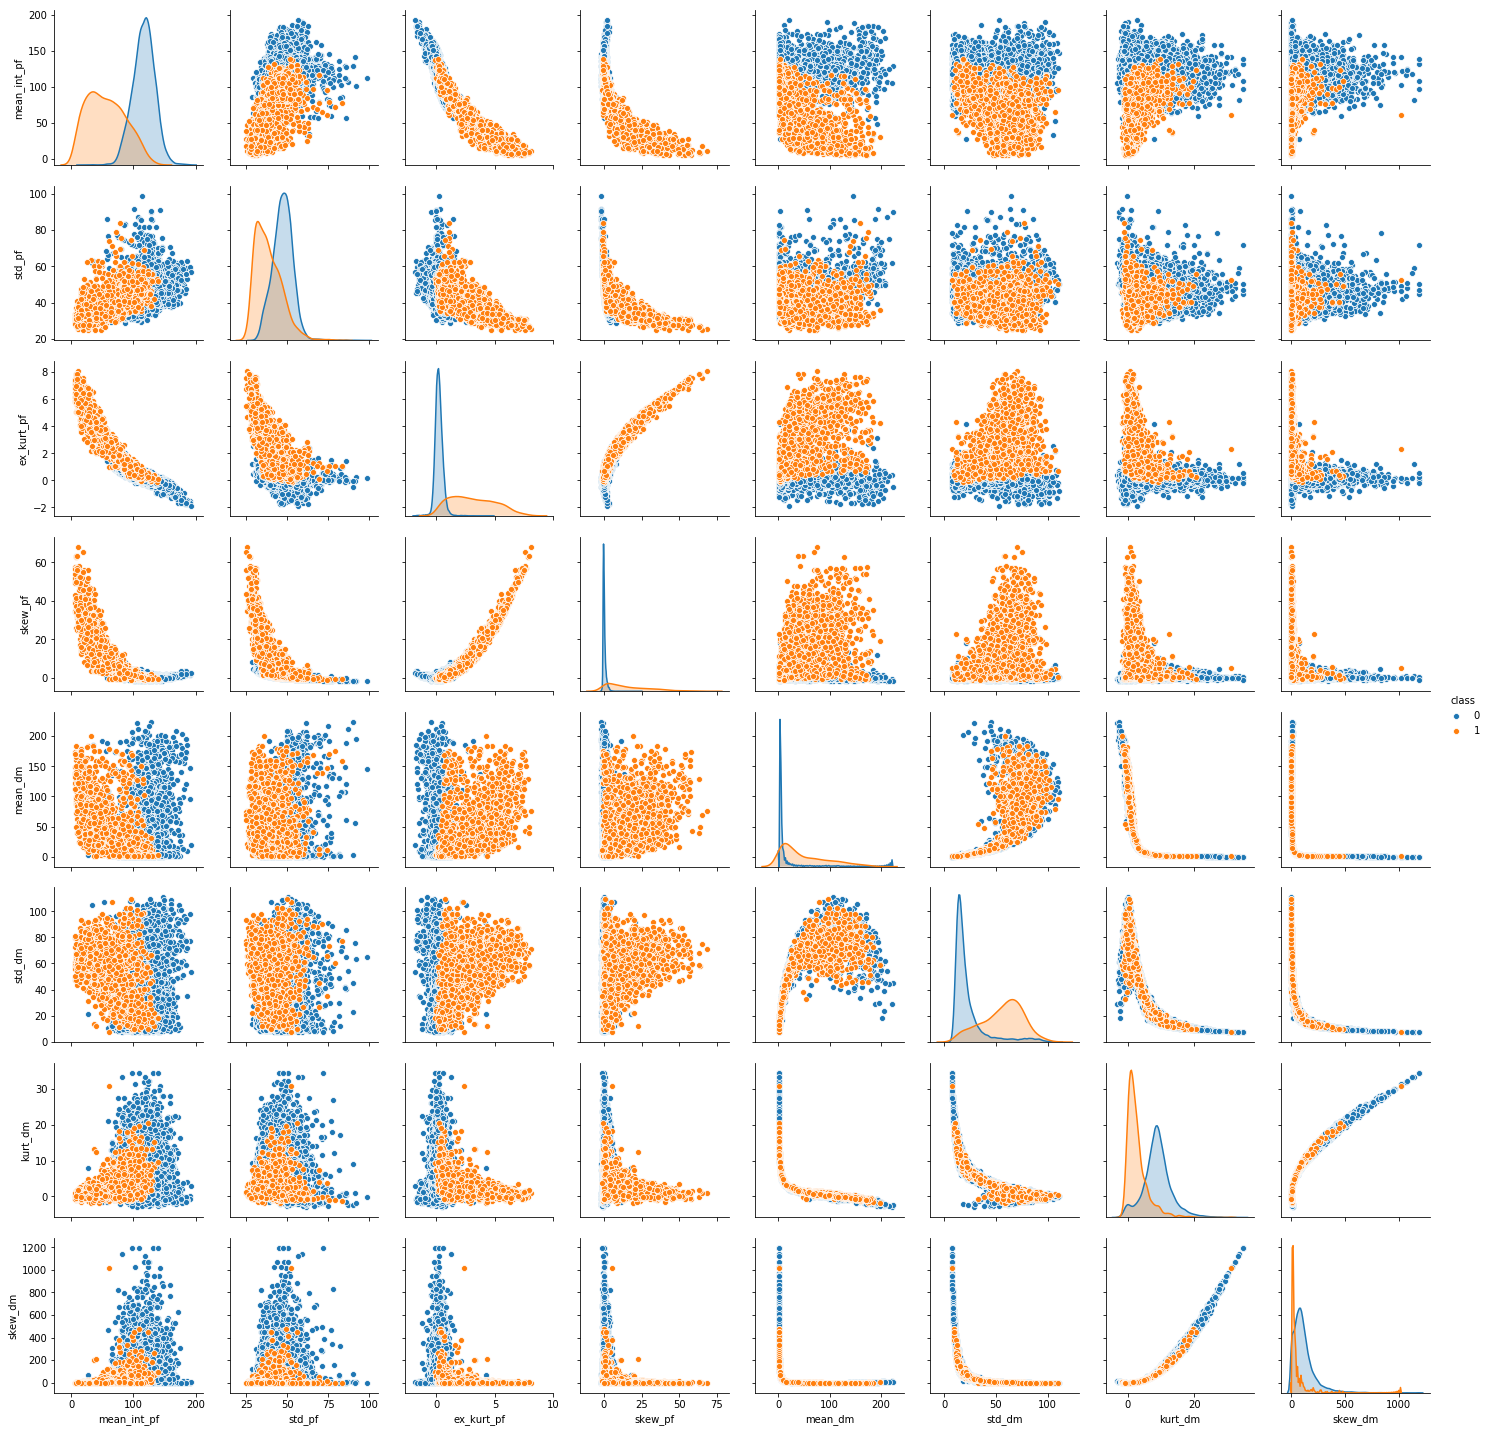

In [29]:
g = sns.pairplot(df, vars=feature_names, hue="class")

When there are lots of individual data points in a plot then using something like the [datashader library](https://seaborn.pydata.org) can make it look nicer:

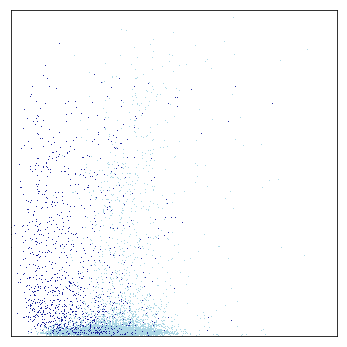

In [53]:
cvs = ds.Canvas(plot_width=400, plot_height=400)
agg = cvs.points(df, 'std_pf', 'mean_dm', ds.sum('class'))
img = tf.shade(agg, color_key=color_key, how='eq_hist')

utils.export_image(img, filename='shader_test', background='white')

image = pl.imread('shader_test.png')
fig, ax = pl.subplots(figsize=(6, 6))
pl.imshow(image)
pl.setp(ax, xticks=[], yticks=[])

pl.show()

-----

Now let's get back to building our classifier. We need to split our labelled data into two separate datasets: one to train the classifier and one to test the fitted machine learning model. 

To do this we can use the function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from the [scikit_learn](https://scikit-learn.org) library:

In [14]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.33, random_state=66)

---

**Exercise 2:** Once you've run through the tutorial, come back to this point and see what difference changing the relative size of your train:test datasets makes.

---


At this point we now have our dataset in the suitable state to start training our classifier. 

To start with we need to initiate the random forest classifier from [scikit_learn]():

In [15]:
RFC = RandomForestClassifier(n_jobs=2,n_estimators=10)

...and we can immediately fit the machine learning model to our training data:

In [16]:
RFC.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

---

**Exercise 3:** You could try changing the split criterion from the "gini" ([Gini impurity](https://victorzhou.com/blog/gini-impurity/)) to "entropy" (information gain). Does it make a difference?

---

We can then used the trained classifier to predict the label for the test data that we split out earlier:

In [17]:
rfc_predict = RFC.predict(X_test)

So how did we do? We need to evaluate the performance of our classifier.

A good first step is to evaluate the [cross-validation](https://www.openml.org/a/estimation-procedures/1). This will tell us how well our machine learning model *generalises*, i.e. whether we have over-fitted the training data.

In [18]:
rfc_cv_score = cross_val_score(RFC, features, targets, cv=10, scoring='roc_auc')

Let's print out the various evaluation criteria:

In [19]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict, target_names=['Non Pulsar','Pulsar']))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[5329   33]
 [  94  451]]


=== Classification Report ===
              precision    recall  f1-score   support

  Non Pulsar       0.98      0.99      0.99      5362
      Pulsar       0.93      0.83      0.88       545

   micro avg       0.98      0.98      0.98      5907
   macro avg       0.96      0.91      0.93      5907
weighted avg       0.98      0.98      0.98      5907



=== All AUC Scores ===
[0.91494727 0.94436632 0.95885834 0.96186774 0.96888969 0.94619821
 0.95401892 0.94685822 0.96764655 0.9669882 ]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9530639463494683


Although they are useful as they are, a visualisation of these numbers can provide a much more efficient and accessible way to interpret the performance of our classifier.

We can make a more visual representation of the confusion matrix using the [scikit-plot]() library. To do this we need to know the predictions from our cross validation, rather than the Area Under Curve ([AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)) value:

In [20]:
predictions = cross_val_predict(RFC, features, targets, cv=2)

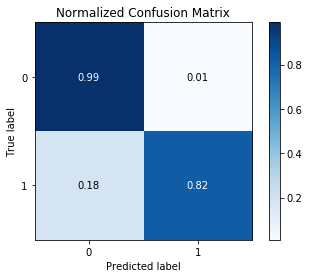

In [21]:
skplt.metrics.plot_confusion_matrix(targets, predictions, normalize=True)

To plot the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) we need to find the probabilities for each target class separately. We can do this with the [predict_proba]() function:

In [22]:
probas = RFC.predict_proba(X_test)

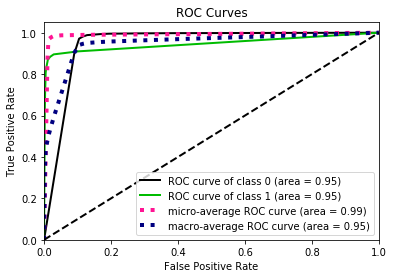

In [23]:
skplt.metrics.plot_roc(y_test, probas)

In a balanced data set there should be no difference between the micro-average ROC curve and the macro-average ROC curve. In the case where there is a class imbalance (like here), if the **macro** ROC curve is *lower* than the micro-ROC curve then there are more cases of mis-classification in minority class. [Longer description here](http://rushdishams.blogspot.com/2011/08/micro-and-macro-average-of-precision.html)

---

**Exercise 4:** What is the ROC curve here telling us?

---

**Exercise 5:** What is the difference between the [RFC.predict( )](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict) function and the [RFC.predict_proba( )](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba) function?

---




We can use the output of the RFC.predict_proba( ) function to plot a Precision-Recall Curve. Recall that,

$$Precision = \frac{TP}{TP+FP},$$

$$Recall = \frac {TP}{TP+FN}.$$

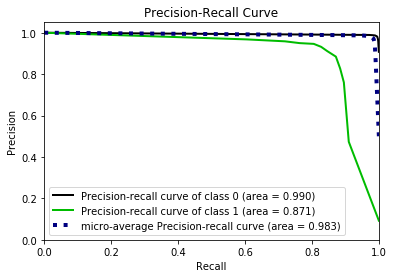

In [24]:
skplt.metrics.plot_precision_recall(y_test, probas)

When we initiated the random forest classifier we picked a value for the number of trees in our forest - but how do we know that this is the best possible value? 

We can use a "grid search" to loop through different options (e.g. number of trees, number of features for each tree, maximum depth of a tree) and tell us which one performs best.

In [25]:
from sklearn.model_selection import RandomizedSearchCV

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]

# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)

# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }

# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = RFC, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the model
rfc_random.fit(X_train, y_train)

# print results
print(rfc_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

We can then re-run our training with the optimal parameters.

---

**Exercise 6:** Can you re-write the first line of Python in the next cell so that it automatically uses the best parameters?

---

In [ ]:
rfc2 = RandomForestClassifier(n_estimators=2000, max_depth=100, max_features='sqrt')
rfc2.fit(X_train,y_train)
rfc2_predict = rfc.predict(X_test)
rfc2_cv_score = cross_val_score(rfc2, features, targets, cv=10, scoring='roc_auc')

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc2_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc2_predict, target_names=['Non Pulsar','Pulsar']))
print('\n')
print("=== All AUC Scores ===")
print(rfc2_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc2_cv_score.mean())

Let's take a look at the relative importance of the different features that we fed to our classifier:

In [ ]:
importances = rfc2.feature_importances_
indices = np.argsort(importances)

...and let's visualise the results:

In [ ]:
pl.figure(1)
pl.title('Feature Importances')
pl.barh(range(len(indices)), importances[indices], color='b', align='center')
pl.yticks(range(len(indices)), feature_names[indices])
pl.xlabel('Relative Importance')
 
pl.show()